### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 5
### Due: Friday, Mar 7nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [12]:
### load data
import numpy as np
data = np.load('hw_data/hw5_data_1.npy')

#print(data)

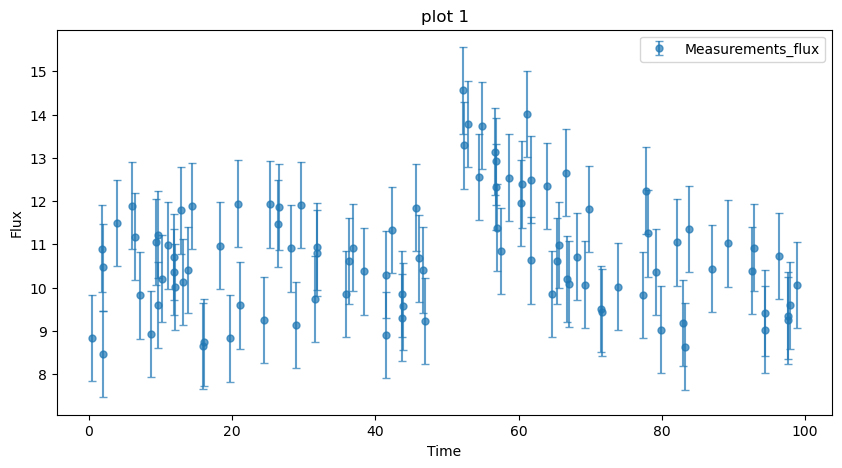

In [14]:
### imports
import numpy as np
import matplotlib.pyplot as plt

### each columns
time = data[:, 0]
flux = data[:, 1]
uncertainties = data[:, 2]

### plot
plt.figure(figsize=(10, 5))
plt.xlabel("Time")
plt.ylabel("Flux")
plt.errorbar(time, flux, yerr=uncertainties, fmt='o', markersize=5,
             capsize=3, label='Measurements_flux', alpha=0.7)
plt.title("plot 1")
plt.legend()
plt.show()

100%|██████████████████████████████████████| 5000/5000 [00:12<00:00, 412.29it/s]


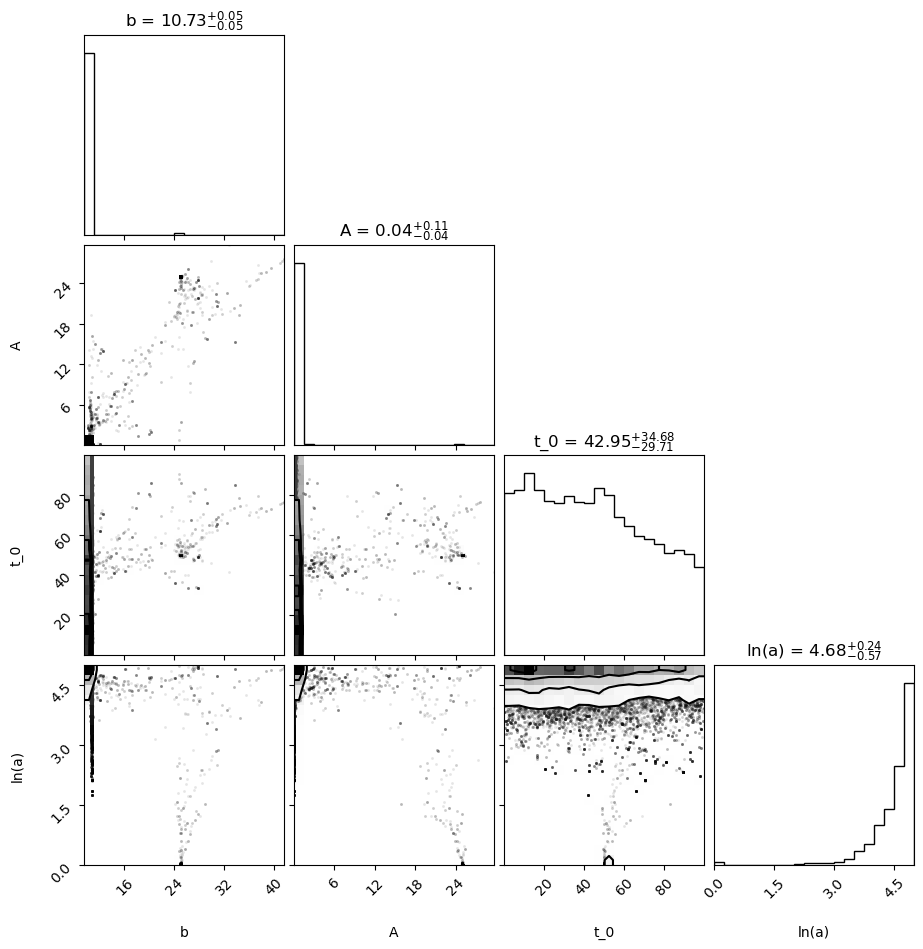

In [48]:
### import
import emcee
import corner

### models
def burst_model(params, t): # Burst model
    b, A, t_0, log_alpha = params
    alpha = np.exp(log_alpha)
    return b + A * ((t - t_0) / alpha)**2

def log_likelihood(params, t, y, yerr): # Log likelihood function
    model_values = burst_model(params, t)
    return -0.5 * np.sum(((y - model_values) / yerr) ** 2)

### prior and posterior (prev. notes and gpt)
def log_prior(params):
    b, A, t_0, log_alpha = params # this is smart (gpt modified it this way)
    if 0 < b < 50 and 0 < A < 50 and 0 < t_0 < 100 and -5 < log_alpha < 5:
        return 0.0  # uniform prior
    return -np.inf  # zero likelihood for out-of-bounds values

def log_posterior(params, t, y, yerr):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, t, y, yerr)

### MCMC
ndim = 4  # b, A, t_0, log_alpha
nwalkers = 100
nsteps = 5000
initial_guess = [25, 25, 50, 0]  # arbitrary num
p0 = [initial_guess + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

t_data = data[:, 0]
y_data = data[:, 1]
yerr = 0.5  

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t_data, y_data, yerr))
sampler.run_mcmc(p0, nsteps, progress=True)
samples = sampler.get_chain(flat=True)

burn_in = 1000
thin = 10
samples_burned_thinned = samples[burn_in::thin]

### corner plot (feat. gpt)
import corner
corner.corner(samples_burned_thinned, labels=["b", "A", "t_0", "ln(a)"], show_titles=True)

plt.show()
### pops a warning of 
### "WARNING:root:Too few points to create valid contours"
### but still grpahs something!

<span style="color:red">NP: missing chain convergence checks. -1 pt </span>

<span style="color:red">NP: Your model is incorrect. You forgot the part about that model only being valid for t > t0, and that is having an effect on your fitting as you can see in the next panel. -2 pt.</span>

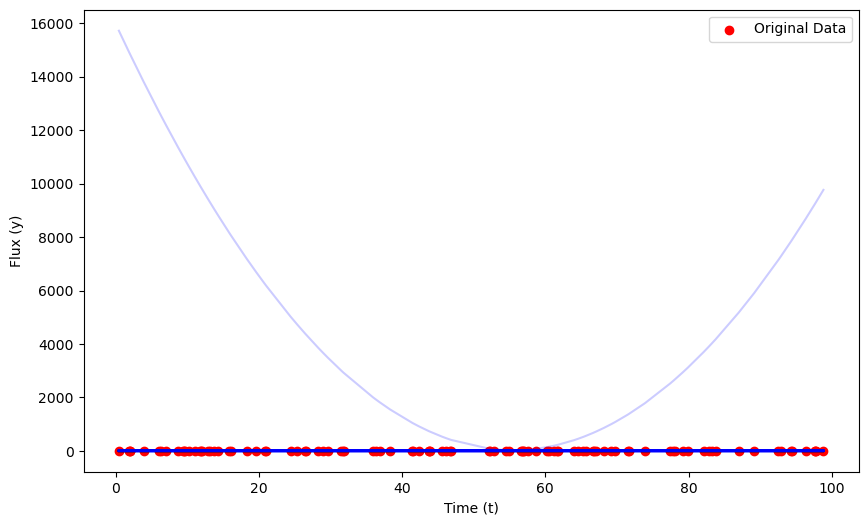

In [50]:
### 100 random samples
random_samples = np.random.choice(samples_burned_thinned.shape[0], size=100)
plt.figure(figsize=(10, 6))

for i in random_samples:
    b, A, t_0, log_alpha = samples_burned_thinned[i]
    model_y = burst_model([b, A, t_0, log_alpha], t_data)
    plt.plot(t_data, model_y, color='blue', alpha=0.2)  # Transparent curves

### plot
plt.scatter(t_data, y_data, color='red', label="Original Data")
plt.xlabel("Time (t)")
plt.ylabel("Flux (y)")
plt.legend()
plt.show()

<span style="color:red">NP: This also should have told you that you are doing something incorrect. -1 pt</span>

In [54]:
### imports
import dynesty
# import UltraNest << Hmmm... DNE

In [72]:
### Gaussian model
def gaussian_model(params, t):
    b, A, t_0, log_sigma_W = params
    sigma_W = np.exp(log_sigma_W)
    return b + A * np.exp(-(t - t_0) ** 2 / (2 * sigma_W ** 2))

### Log likelihood for Gaussian
def log_likelihood_gaussian(params, t, y, yerr):
    model_values = gaussian_model(params, t)
    return -0.5 * np.sum(((y - model_values) / yerr) ** 2)

### Log prior and posterior
def log_prior_gaussian(params):
    b, A, t_0, log_sigma_W = params
    if 0 < b < 50 and 0 < A < 50 and 0 < t_0 < 100 and -2 < log_sigma_W < 2:
        return 0.0
    return -np.inf

def log_posterior_gaussian(params, t, y, yerr):
    lp = log_prior_gaussian(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_gaussian(params, t, y, yerr)


In [76]:
### nested sampler
ndim_gaussian = 4  # b, A, t_0, log(sigma_W)
nlive = 500

t_data = data[:, 0]
y_data = data[:, 1]
yerr = 0.5 # assume

### nested sampler
sampler_gaussian = dynesty.NestedSampler(
    log_posterior_gaussian, log_prior_gaussian, ndim_gaussian, 
    nlive=nlive, bound='multi', sample='rwalk', 
    logl_args=(t_data, y_data, yerr)
)
sampler_gaussian.run_nested()
results_gaussian = sampler_gaussian.results

evidence_gaussian = results_gaussian['logz'][-1]
print(f"Log evidence for Gaussian model: {evidence_gaussian}")

### plot
import corner
corner.corner(results_gaussian['samples'], labels=["b", "A", "t_0", "ln(σ_W)"], show_titles=True)

plt.show()

### I can't figure out the last part
### tried to fix errors with gpt as well, but not really working :(

Exception while calling loglikelihood function:
  params: 0.0
  args: (array([ 0.46954762,  1.87898004,  2.01075462,  2.02183974,  3.91877923,
        6.02254716,  6.41474963,  7.10360582,  8.71292997,  9.39405108,
        9.60984079,  9.71012758, 10.20448107, 11.03751412, 11.82744259,
       11.8727719 , 12.01965612, 12.89262977, 13.17978624, 13.81829513,
       14.33532874, 15.89695836, 16.13095179, 18.3191362 , 19.65823617,
       20.88767561, 21.03825611, 24.4425592 , 25.32916025, 26.45556121,
       26.53894909, 28.28069626, 28.94060929, 29.61401975, 31.54283509,
       31.79831794, 31.85689525, 35.95079006, 36.37107709, 36.87251707,
       38.34415188, 41.42629945, 41.466194  , 42.36547993, 43.70319538,
       43.75872113, 43.86015135, 45.61503322, 46.14793623, 46.63107729,
       46.86512016, 52.18483218, 52.32480535, 52.88949198, 54.4883183 ,
       54.88135039, 56.66014542, 56.80445611, 56.84339489, 57.01967704,
       57.59464956, 58.65129348, 60.27633761, 60.48455197, 61.209

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/dynesty/dynesty.py", line 913, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/h1/kqtnsfh94qlfjmw5vf4wkdkh0000gn/T/ipykernel_40246/2894953210.py", line 20, in log_posterior_gaussian
    lp = log_prior_gaussian(params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/h1/kqtnsfh94qlfjmw5vf4wkdkh0000gn/T/ipykernel_40246/2894953210.py", line 14, in log_prior_gaussian
    b, A, t_0, log_sigma_W = params
    ^^^^^^^^^^^^^^^^^^^^^^
TypeError: iteration over a 0-d array


TypeError: iteration over a 0-d array

In [79]:
### for some reason my internet is a little funky.
### chrome repeatedly pops up t-rex game
### I will try to upload things as soon as I get up on Saturday morning.
### not even sure if this will be saved safely

<span style="color:red">NP: incomplete #7. -2 pt </span>